In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import toml
import seaborn as sns
import pandas as pd

from tqdm.auto import tqdm
from qd_analysis.fig import setup_plotting_env
from scipy.optimize import least_squares

In [3]:
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c


def power_law_decay(x, a, b, c):
    return a / ((x + 1.0) ** b) + c


def power_law_decay_inv(x, a, b, c):
    return a * (1 - 1 / ((x + 1.0) ** b)) + c

In [4]:
def fit_curve_power_law(
    vals,
    x="nframes_train",
    y="test_dist.avg",
    bounds=([1e-6, 0.01, 1e-6, -np.inf], [1e6, 10, 100, np.inf]),
    domain=(50, int(1e5)),
    invert=False,
    loss="linear",
    method="trf",
):
    eval_points = np.arange(domain[0], domain[1], 100)
    use_x, use_y = vals.index, vals.values
    idx = (use_x >= domain[0]) & (use_x <= domain[1])
    use_x = use_x[idx]
    use_y = use_y[idx]

    y_min = np.nanmin(use_y)
    y_max = np.nanmax(use_y)

    if invert:
        x0_guess = [1.0, 0.05, 0.0]
    else:
        x0_guess = [1.0, 0.05, 0.0]
    # Bounds: (min, max) for a, b, c
    lower_bounds = [1e-6, 0.01, -1e2]
    upper_bounds = [1e3, 1.0, 1e2]

    # Residuals for least_squares
    use_func = power_law_decay if not invert else power_law_decay_inv

    def residuals(params, x, y):
        a, b, c = params
        return use_func(x, a, b, c) - y

    result = least_squares(
        residuals,
        x0_guess,
        args=(use_x, use_y),
        bounds=(lower_bounds, upper_bounds),
        method=method,
        loss=loss,
        f_scale=1.0,  # threshold for switching between L2 and L1
    )
    return (
        eval_points,
        use_func(eval_points, *result.x),
        dict(
            list(
                zip(
                    [
                        "a",
                        "b",
                        "c",
                    ],
                    result.x,
                )
            )
        ),
    )

# Parse grid search

1. TODO: need to check mAP test/train to see how robust learning is
2. TODO: match 1 with overall performance (maybe equal weighting after normalize?)

In [5]:
config = toml.load("../preprocessing/config.toml")
save_file = os.path.join(config["dirs"]["data"], "dataframes/sleap_metrics_qd_training.parquet")

fig_dir = config["dirs"]["figs"]
os.makedirs(fig_dir, exist_ok=True)

In [6]:
df = pd.read_parquet(save_file)

In [7]:
use_y = "test_dist.avg"
domain = (50, 2e5)

In [8]:
# save off results so we're not waiting!

In [9]:
# repeat this 1000 times
fits = []
dfs = []
nboots = 1000
for _boot in tqdm(range(nboots)):
    boot_fit = (
        df.set_index("nframes_train")
        .groupby(["is_joint", "condition"])[use_y]
        .apply(
            lambda x: fit_curve_power_law(
                x.sample(len(x), replace=True),
                y=use_y,
                domain=domain,
            ),
            include_groups=False,
        )
    )
    for (is_joint, condition), (eval_points, fit, parameters) in boot_fit.items():
        _df = pd.DataFrame()
        _df["eval_points"] = eval_points
        _df["fit"] = fit
        _df["is_joint"] = is_joint
        _df["condition"] = condition
        _df["nboot"] = _boot
        for k, v in parameters.items():
            _df[f"parameters.{k}"] = v
        dfs.append(_df)

boot_df = pd.concat(dfs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
def get_threshold_crossing(x, threshold=4.9):
    idx = x[x <= threshold].index
    try:
        return min(idx)
    except ValueError:
        return np.nan

In [11]:
# thresholds = [6.12, 4.9, 2.45] # 2.5, 2, 1
thresholds = [4.9, 2.45]

In [12]:
threshold_dict = {}
for _threshold in thresholds:
    threshold_crossings = boot_df.groupby(["is_joint", "condition", "nboot"]).apply(
        lambda x: get_threshold_crossing(x.set_index("eval_points")["fit"], threshold=_threshold), include_groups=False
    )
    med_crossings = threshold_crossings.groupby(["is_joint","condition"]).median()
    key = str(_threshold)
    threshold_dict[key] = {}
    threshold_dict[key]["standard"] = med_crossings.loc[False].to_dict()
    threshold_dict[key]["kneejoints"] = med_crossings.loc[True].to_dict() 

In [13]:
with open(os.path.join(fig_dir, "autolabel_threshold_crossings.toml"), "w") as f:
    toml.dump(threshold_dict, f)

In [14]:
print(threshold_dict)

{'4.9': {'standard': {'all': 850.0, 'different': 18950.0, 'same': 450.0}, 'kneejoints': {'all': 350.0, 'different': 3250.0, 'same': 250.0}}, '2.45': {'standard': {'all': 88350.0, 'different': nan, 'same': 26350.0}, 'kneejoints': {'all': nan, 'different': nan, 'same': 47550.0}}}


In [15]:
linestyles = ["--", ":"]
magnification = 0.008 / 0.3048  # focal length / object distance
pixelsize = 5.5e-6
nyquist_limit = pixelsize / magnification * 2.3 * 1e3  # convert to mm
mm_per_px = 0.4086988622772185  # at 12 inches away
theoretical_limit = nyquist_limit / mm_per_px

In [16]:
setup_plotting_env()

In [17]:
ylims = {True: (1., 10),
         False: (1., 100)}

In [18]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [19]:
colors = {
    "same": "tab:green",
    "all": "tab:blue",
    "different": "tab:orange",
}

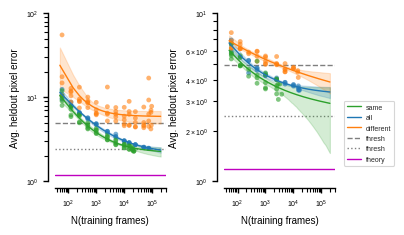

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(4.0, 2.3), sharex=True, sharey=False)
for _is_joint, _ax in zip([False, True], ax):

    sns.lineplot(
        boot_df.query("is_joint == @_is_joint"),
        x="eval_points",
        y="fit",
        errorbar=("pi", 95),
        palette=colors,
        hue_order=list(colors.keys()),
        hue="condition",
        legend=False,
        ax=_ax,
    )

    sns.scatterplot(
        df.query("is_joint == @_is_joint and nframes_train.between(50,1e5)"),
        x="nframes_train",
        y=use_y,
        hue="condition",
        hue_order=list(colors.keys()),
        palette=colors,
        alpha=0.6,
        clip_on=False,
        ec="none",
        legend=False,
        lw=0,
        s=12,
        ax=_ax,
    )

    fit_lines = list(_ax.lines)
    fit_labels = list(colors.keys())
    for _threshold, _ls in zip(thresholds, linestyles):
        l = _ax.axhline(y=_threshold, zorder=-500, color="k", ls=_ls, alpha=0.5, label="thresh")
        fit_lines.append(l)
        fit_labels.append("thresh")
    l = _ax.axhline(y=theoretical_limit, zorder=-500, color="m", ls="-", alpha=1.0, label="theory")
    fit_lines.append(l)
    fit_labels.append("theory")

_ax.legend(handles=fit_lines, labels=fit_labels, bbox_to_anchor=(1.05, 0.5))

for _is_joint, _ax in zip([False, True], ax):
    _ax.set_xscale("log")
    _ax.set_yscale("log")
    _ax.set_ylim(*ylims[_is_joint])
    _ax.set_xlabel("")
    _ax.set_ylabel("Avg. heldout pixel error")
    _ax.set_xlabel("N(training frames)")
fig.tight_layout()
sns.despine(offset=5, trim=False)
fig.savefig(os.path.join(fig_dir, "autolabel_keypoint_tracker_pixelerror.pdf"), bbox_inches="tight", dpi=600)

# Body parts

In [21]:
body_parts_cols = df.query("~is_joint").filter(regex="test_dist.parts").dropna(axis=1).columns
body_parts = [_part.split(".")[-1] for _part in body_parts_cols]

In [22]:
df["filename"].iat[0]

'/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training_round2/keypoints_from_qds_all_cameras_kneejoints_v3/models/unet_filters-64_max_stride-64_training_labels-kpoint_training_dataset_qd_alignment_kneejoints_reflect_only_round2_manual_labeling_nofluo_version-v1-embed-False.slp_training_subsample-60_repeat-0.single_instance/initial_config.json'

In [23]:
df.query("condition == 'all' and nframes_train == 1000").groupby(["nframes_train","filename"])[body_parts_cols].mean().mean()

test_dist.parts.foreleg_L      8.052452
test_dist.parts.foreleg_R      6.977166
test_dist.parts.hindleg_L      4.502418
test_dist.parts.hindleg_R      4.320263
test_dist.parts.back_top       3.833876
test_dist.parts.back_middle    4.377209
test_dist.parts.back_bottom    4.193759
test_dist.parts.tail_base      3.519257
test_dist.parts.tail_middle    5.899094
test_dist.parts.tail_tip       4.744229
dtype: float64

In [24]:
# repeat this 1000 times
fits = []
dfs = []
nboots = 1000
for _boot in tqdm(range(nboots)):
    boot_fit = (
        df.dropna(subset=body_parts_cols).set_index("nframes_train").groupby(["is_joint","condition"])[body_parts_cols].agg(
            lambda x: fit_curve_power_law(
                x.sample(len(x), replace=True),
                y=use_y,
                domain=domain,
            ),
            # include_groups=False,
        )
    )
    for (col, body_part) in zip(body_parts_cols, body_parts):
        for (is_joint, condition), (eval_points, fit, parameters) in boot_fit[col].items():
            _df = pd.DataFrame()
            _df["eval_points"] = eval_points
            _df["fit"] = fit
            _df["is_joint"] = is_joint
            _df["condition"] = condition
            _df["nboot"] = _boot
            _df["kpoint"] = body_part
            for k, v in parameters.items():
                _df[f"parameters.{k}"] = v
            dfs.append(_df)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
boot_df_kpoints = pd.concat(dfs)

In [26]:
plt_points = df.set_index(["is_joint", "condition", "nframes_train"])[body_parts_cols]
plt_points.columns = body_parts
plt_points = plt_points.melt(ignore_index=False, var_name="kpoint").reset_index()

In [27]:
kpoint_aliases = {
    "foreleg_L": "Left forepaw",
    "foreleg_R": "Right forepaw",
    "hindleg_L": "Left hindpaw",
    "hindleg_R": "Right hindpaw",
    "tail_tip": "Tail tip",
    "tail_middle": "Tail middle",
    "tail_base": "Tail base",
    "back_bottom": "Back bottom",
    "back_middle": "Back middle",
    "back_top": "Back top",
}

In [28]:
boot_df_kpoints["kpoint_alias"] = boot_df_kpoints["kpoint"].map(kpoint_aliases)
plt_points["kpoint_alias"] = plt_points["kpoint"].map(kpoint_aliases)


In [29]:
hue_order = list(kpoint_aliases.values())

In [30]:
conditions = ["different", "same", "all"]

/tmp/ipykernel_243248/2551484588.py:45: UserWarning: Mismatched number of handles and labels: len(handles) = 13 len(labels) = 19
  ax[-1].legend(handles=fit_lines, labels=fit_labels, bbox_to_anchor=(1.05, 1.0))


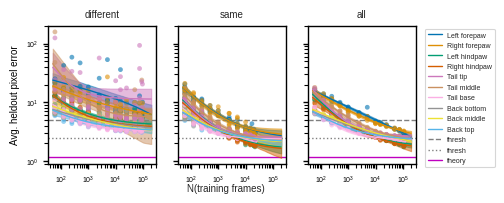

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(4.75, 1.8), sharex=True, sharey=True)
for _ax, _condition in zip(ax, conditions):
    sns.lineplot(
        boot_df_kpoints.query("~is_joint and condition == @_condition"),
        x="eval_points",
        y="fit",
        errorbar=("pi", 95),
        err_kws={"alpha": 0.5},
        palette="colorblind",
        hue_order=hue_order,
        legend=False,
        hue="kpoint_alias",
        ax=_ax,
    )
    sns.scatterplot(
        plt_points.query("~is_joint and condition == @_condition"),
        x="nframes_train",
        y="value",
        hue="kpoint_alias",
        hue_order=hue_order,
        palette="colorblind",
        alpha=0.6,
        clip_on=False,
        ec="none",
        legend=False,
        lw=0,
        s=12,
        ax=_ax,
    )

    fit_lines = list(_ax.lines)
    fit_labels = hue_order
    for _threshold, _ls in zip(thresholds, linestyles):
        l = _ax.axhline(y=_threshold, zorder=-500, color="k", ls=_ls, alpha=0.5, label="thresh")
        fit_lines.append(l)
        fit_labels.append("thresh")
    l = _ax.axhline(y=theoretical_limit, zorder=-500, color="m", ls="-", alpha=1.0, label="theory")
    fit_lines.append(l)
    fit_labels.append("theory")
    _ax.set_title(_condition)
    _ax.set_xlabel("")
    _ax.set_ylabel("")

ax[0].set_ylabel("Avg. heldout pixel error")
ax[-1].legend(handles=fit_lines, labels=fit_labels, bbox_to_anchor=(1.05, 1.0))
ax[0].set_xscale("log")
ax[0].set_yscale("log")
fig.supxlabel("N(training frames)", fontsize=7, x=0.5, ha="center", y=-0.05)
fig.savefig(
    os.path.join(fig_dir, "autolabel_keypoint_tracker_pixelerror_perbodypart.pdf"), bbox_inches="tight", dpi=600
)

# Other metrics

In [32]:
metric_cols = ["test_vis.precision", "test_vis.recall", "test_oks.mOKS"]
metric_names = ["precision", "recall", "oks"]

In [33]:
# repeat this 1000 times
fits = []
dfs = []
nboots = 1000
for _boot in tqdm(range(nboots)):
    boot_fit = (
        df.dropna(subset=metric_cols).set_index("nframes_train").groupby(["is_joint","condition"])[metric_cols].agg(
            lambda x: fit_curve_power_law(
                x.sample(len(x), replace=True),
                y=use_y,
                invert=True,
                domain=domain,
            ),
            # include_groups=False,
        )
    )
    for (metric, name) in zip(metric_cols, metric_names):
        for (is_joint, condition), (eval_points, fit, parameters) in boot_fit[metric].items():
            _df = pd.DataFrame()
            _df["eval_points"] = eval_points
            _df["fit"] = fit
            _df["is_joint"] = is_joint
            _df["condition"] = condition
            _df["nboot"] = _boot
            _df["metric"] = name 
            for k, v in parameters.items():
                _df[f"parameters.{k}"] = v
            dfs.append(_df)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
boot_df_other_metrics = pd.concat(dfs)

In [35]:
metrics = boot_df_other_metrics["metric"].unique()

In [36]:
plt_points = df.set_index(["is_joint", "condition", "nframes_train"])[metric_cols]
plt_points.columns = metric_names
plt_points = plt_points.melt(ignore_index=False, var_name="metric").reset_index()

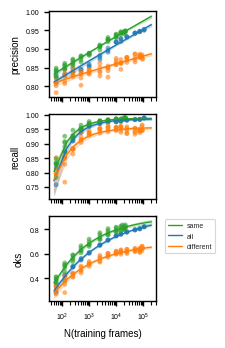

In [37]:
fig, ax = plt.subplots(3, 1, figsize=(2.3, 3.5), sharey=False, sharex=True)
for _metric, _ax in zip(metrics, ax):
    sns.lineplot(
        boot_df_other_metrics.query("~is_joint and metric == @_metric"),
        x="eval_points",
        y="fit",
        errorbar=("pi", 95),
        palette=colors,
        hue="condition",
        hue_order=list(colors.keys()),
        legend=False,
        ax=_ax,
    )
    sns.scatterplot(
        plt_points.query("~is_joint and metric == @_metric"),
        x="nframes_train",
        y="value",
        hue="condition",
        palette=colors,
        hue_order=list(colors.keys()),
        alpha=0.6,
        clip_on=False,
        ec="none",
        legend=False,
        lw=0,
        s=12,
        ax=_ax,
    )
    _ax.set_ylabel(_metric)
    _ax.set_xlabel("")
ax[-1].set_xscale("log")
fit_lines = list(ax[-1].lines)
ax[-1].legend(handles=fit_lines, labels=list(colors.keys()), bbox_to_anchor=(1.05,1.))
ax[-1].set_xlabel("N(training frames)")
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, "autolabel_keypoint_tracker_othermetrics.pdf"), bbox_inches="tight", dpi=600)